# Kera, Example.

Load the fashion MNIST dataset and train it using Keras. For classification.

### Common Deep Learning Layers

| Layer Type            | Purpose / Function                                 | Typical Use Case                 | Key Parameters                  |
|-----------------------|----------------------------------------------------|----------------------------------|---------------------------------|
| **Dense (Fully Connected)** | Linear transformation + bias                   | MLPs, classifier heads            | units, activation               |
| **Convolutional (Conv1D/2D/3D)** | Extract spatial/temporal features via filters | Images, audio, video              | filters, kernel size, stride    |
| **Pooling (Max, Avg)** | Downsampling feature maps                         | CNNs (after conv layers)          | pool size, stride               |
| **Dropout**            | Randomly deactivate neurons during training        | Regularization                    | dropout rate (e.g., 0.5)        |
| **Batch Normalization**| Normalize across batch to speed up training        | CNNs, MLPs                        | momentum, epsilon               |
| **Activation**         | Add non-linearity                                  | Everywhere                        | type (ReLU, Sigmoid, etc.)      |
| **Flatten**            | Convert N-D input to 1D                            | Before dense layers               | –                               |
| **Reshape**            | Change tensor shape                                | Transition layers                 | target shape                    |
| **Embedding**          | Map categorical IDs to dense vectors               | NLP, recommender systems          | input_dim, output_dim           |
| **RNN / LSTM / GRU**   | Process sequential data with memory                | Time series, NLP                  | units, return_sequences         |
| **Attention / Self-Attention** | Compute weighted importance between inputs  | Transformers, LLMs                | heads, key/query/value dims     |
| **Layer Normalization**| Normalize across features per sample               | Transformers, NLP                 | epsilon                         |

In [1]:
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix
import seaborn as sns
import numpy as np
import pandas as pd
import os
from dnn_helpers import get_all_callbacks, get_adam_optimizer

In [2]:
print(f"TF version: {tf.__version__}, Keras: {keras.__version__}")

TF version: 2.19.0, Keras: 3.10.0


In [3]:
fashion = keras.datasets.fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion.load_data()

In [4]:
print(f"Shapes: {X_train.shape}, {y_train.shape}, type: {type(X_train)}")
print(f"Test: {X_test.shape}, {y_test.shape}, type: {type(X_test)}")
# the y_train is index into following
#   https://keras.io/api/datasets/fashion_mnist/
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]
X_test = X_test / 255.0
X_train = X_train / 255.0

Shapes: (60000, 28, 28), (60000,), type: <class 'numpy.ndarray'>
Test: (10000, 28, 28), (10000,), type: <class 'numpy.ndarray'>


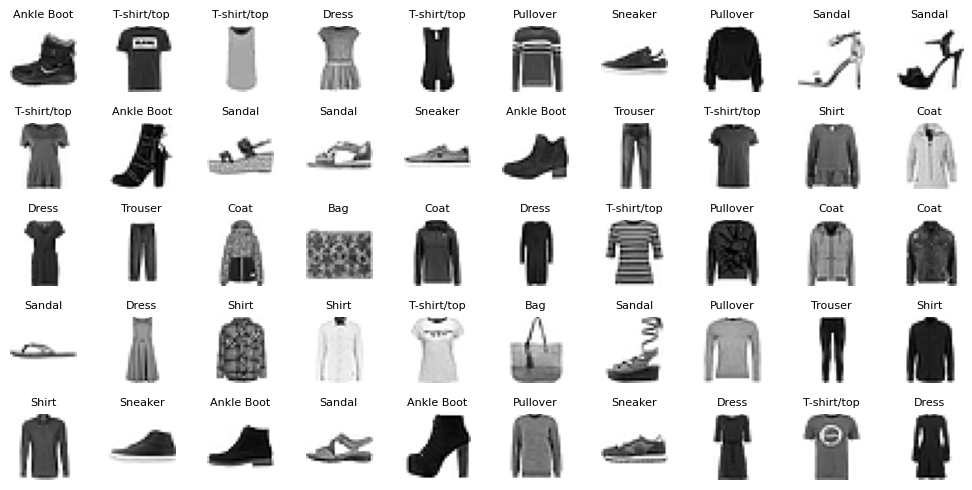

10 items-classes shown


In [5]:
# Show few images
fig, axes = plt.subplots(5,10, figsize=(10,5))
axes = axes.flatten()
items = set()
for idx, ax in enumerate(axes):
    ax.imshow(X_train[idx], cmap="binary")
    ax.set_title(f"{class_names[y_train[idx]]}", size=8)
    ax.axis('off')
    ax.set_facecolor('none')
    items.add(y_train[idx])
plt.tight_layout()
plt.show()
print(f"{len(items)} items-classes shown")

# Linear Models

1. __Input Layer: keras.layers.Input(shape=[28,28])__:
    - __Purpose:__ Specifies the shape of the input data.
    - __Shape:__ The input is a 2D tensor of shape [28, 28]
    - __Connection:__ This layer doesn’t compute anything; it just defines the input shape. The output (shape [28, 28]) is passed directly to the next layer.
2. __Flatten Layer: keras.layers.Flatten()__:
    - __Purpose:__ Converts the 2D input tensor into a 1D vector.
    - __Input Shape:__ [28, 28] (from the Input layer).
    - __Output Shape:__ The Flatten layer reshapes the input into a 1D vector of size 28 * 28 = 784. So, the output shape is [784].
    - __Connection:__ The 2D tensor is unrolled into a single vector of 784 elements, which is then fed into the next layer (Dense layer with 600 units).
3. __Dense Layer 1: keras.layers.Dense(600, activation="relu")__:
    - __Purpose:__ A fully connected layer with 600 neurons, using ReLU activation.
    - __Input Shape:__ [784] (from the Flatten layer).
    - __Output Shape:__ [600] (one output per neuron).
    - __Computation:__ Each of the 600 neurons is connected to all 784 inputs from the Flatten layer. A weighted sum is computed (W * X + b), where W is a weight matrix of shape [784, 600] and b is a bias vector of shape [600]. The ReLU activation (max(0, x)) is applied to the result.
    - __Connection:__ The output (a vector of size 600) is passed to the next Dense layer.
4. __Dense Layer 2: keras.layers.Dense(300, activation="relu")__:
    - __Purpose:__ A fully connected layer with 300 neurons, using ReLU activation.
    - __Input Shape:__ [600] (from the previous Dense layer).
    - __Output Shape:__ [300].
    - __Computation:__ Each of the 300 neurons is connected to all 600 inputs. The weight matrix is [600, 300], and the bias vector is [300]. ReLU activation is applied.
    - __Connection:__ The output (a vector of size 300) is fed into the next Dense layer.
5. __Dense Layer 3: keras.layers.Dense(100, activation="relu")__:
    - __Purpose:__ A fully connected layer with 100 neurons, using ReLU activation.
    - __Input Shape:__ [300] (from the previous Dense layer).
    - __Output Shape:__ [100].
    - __Computation:__ Each of the 100 neurons is connected to all 300 inputs. The weight matrix is [300, 100], and the bias vector is [100]. ReLU activation is applied.
    - __Connection:__ The output (a vector of size 100) is passed to the final Dense layer.
6. __Output Layer: keras.layers.Dense(10, activation="softmax")__:
    - __Purpose:__ A fully connected layer with 10 neurons, using Softmax activation for multi-class classification.
    - __Input Shape:__ [100] (from the previous Dense layer).
    - __Output Shape:__ [10].
    - __Computation:__ Each of the 10 neurons is connected to all 100 inputs. The weight matrix is [100, 10], and the bias vector is [10]. The Softmax activation normalizes the outputs into a probability distribution over the 10 classes (e.g., digits 0-9 for fashion MNIST).
    -  __Connection:__ This is the final layer, so its output (a vector of size 10) represents the model’s predictions.

In [6]:
reg = keras.regularizers.l2(0.0005)
def  build_linear_model():
    model = keras.models.Sequential(
        [
            keras.layers.Input(shape=[28, 28]),
            keras.layers.Flatten(),
            keras.layers.Dense(600, activation=tf.nn.relu,
                               kernel_regularizer=reg),
            keras.layers.Dense(300, activation=tf.nn.relu,
                               kernel_regularizer=reg),
            keras.layers.Dense(100, activation=tf.nn.relu,
                               kernel_regularizer=reg),
            keras.layers.Dense(10, activation=tf.nn.softmax)
        ]
    )
    model.compile(loss="sparse_categorical_crossentropy",
                   optimizer=get_adam_optimizer(),
                   metrics=["accuracy"])
    return model

In [7]:
# Create a model
model1 = build_linear_model()

history = model1.fit(X_train, y_train, epochs=1_000,
                     batch_size=64,
                     callbacks=get_all_callbacks("model1"),
                     validation_split=0.2,
                     verbose=0)

# Try  CNNs

| Layer (Type)       | Output Shape        | Parameters | Description                                     |
|--------------------|---------------------|------------|-------------------------------------------------|
| Input              | (28, 28, 1)         | 0          | Grayscale image input                          |
| Conv2D             | (28, 28, 32)        | 320        | 32 filters, 3×3 kernel, ReLU, padding='same'   |
| MaxPooling2D       | (14, 14, 32)        | 0          | 2×2 pooling                                    |
| Conv2D             | (14, 14, 64)        | 18,496     | 64 filters, 3×3 kernel, ReLU, padding='same'   |
| MaxPooling2D       | (7, 7, 64)          | 0          | 2×2 pooling                                    |
| Flatten            | (3136,)             | 0          | Flattens 3D volume to 1D vector                |
| Dense              | (128,)              | 401,536    | Fully connected layer with ReLU                |
| Dropout (0.5)      | (128,)              | 0          | Dropout for regularization                     |
| Dense (Output)     | (10,)               | 1,290      | Softmax for 10-class classification            |

In [8]:
model2 = keras.models.Sequential([
    keras.layers.Input(shape=(28, 28, 1)),  # Add channel dimension
    # 1st Convolution Layer
    keras.layers.Conv2D(32, (3, 3), activation=tf.nn.relu, padding="same"),
    keras.layers.MaxPooling2D((2, 2)),
    # 2nd Convolution Layer
    keras.layers.Conv2D(64, (3, 3), activation=tf.nn.relu, padding="same"),
    keras.layers.MaxPooling2D((2, 2)),
    # Flatten Layer
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [9]:
X_train_cnn = X_train[..., np.newaxis]         # shape: (50000, 28, 28, 1)
X_test_cnn = X_test[..., np.newaxis]

model2.compile(loss="sparse_categorical_crossentropy",
               optimizer=get_adam_optimizer(),
               metrics=["accuracy"])


history2 = model2.fit(X_train_cnn, y_train, epochs=1_000,
                      batch_size=64,
                      callbacks=get_all_callbacks("model12"),
                      validation_split=.2,
                      verbose=0)

### Try Linear with Dropout

Drop 30% of layaers randomly.

In [10]:
model3 = keras.models.Sequential(
    [
        keras.layers.Input(shape=(28, 28)),
        keras.layers.Flatten(),
        keras.layers.Dense(600, activation=tf.nn.relu, kernel_regularizer=reg),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(300, activation=tf.nn.relu, kernel_regularizer=reg),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(100, activation=tf.nn.relu, kernel_regularizer=reg),
        keras.layers.Dense(10, activation=tf.nn.softmax)
    ]
)
model3.compile(loss="sparse_categorical_crossentropy",
               optimizer=get_adam_optimizer(),
               metrics=["accuracy"])


history3 = model3.fit(X_train, y_train, epochs=1_000,
                     batch_size=64,
                    callbacks=get_all_callbacks("model3"),
                     validation_split=0.2, verbose=0)

In [11]:
y_pred = model3.predict(X_test, verbose=0)
print(np.argmax(y_pred, axis=1))

[9 2 1 ... 8 1 5]


In [12]:
print(type(X_test), X_test.shape, type(X_train), X_train.shape)
np.any(np.isnan(X_test))

<class 'numpy.ndarray'> (10000, 28, 28) <class 'numpy.ndarray'> (60000, 28, 28)


np.False_

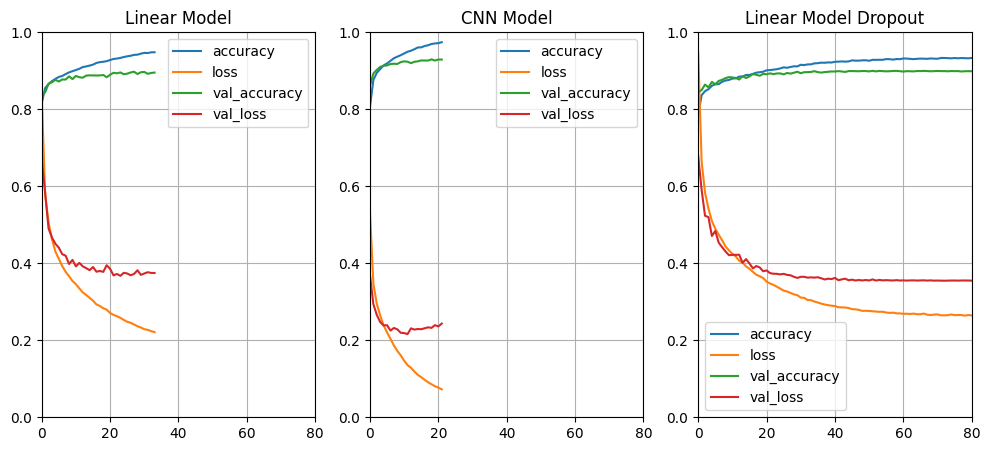

In [13]:
df = pd.DataFrame(history.history)
df2 = pd.DataFrame(history2.history)
df3 = pd.DataFrame(history3.history)
frames = [df, df2, df3]
titles = ["Linear Model", "CNN Model", "Linear Model Dropout"]

fig, axes = plt.subplots(1, 3, figsize=(12, 5))
for idx, ax in enumerate(axes):
    df = frames[idx]
    df.plot(ax=ax)
    ax.grid(True)
    ax.set_ylim(0, 1)
    ax.set_xlim(0, 80)
    ax.set_title(titles[idx])
plt.show()

In [14]:
models = [model1, model2, model3]
test_data = [X_test, X_test_cnn, X_test]
test_labels = [y_test, y_test, y_test]
model_names = ["Linear Model", "CNN Model", "Linear Model Dropout"]

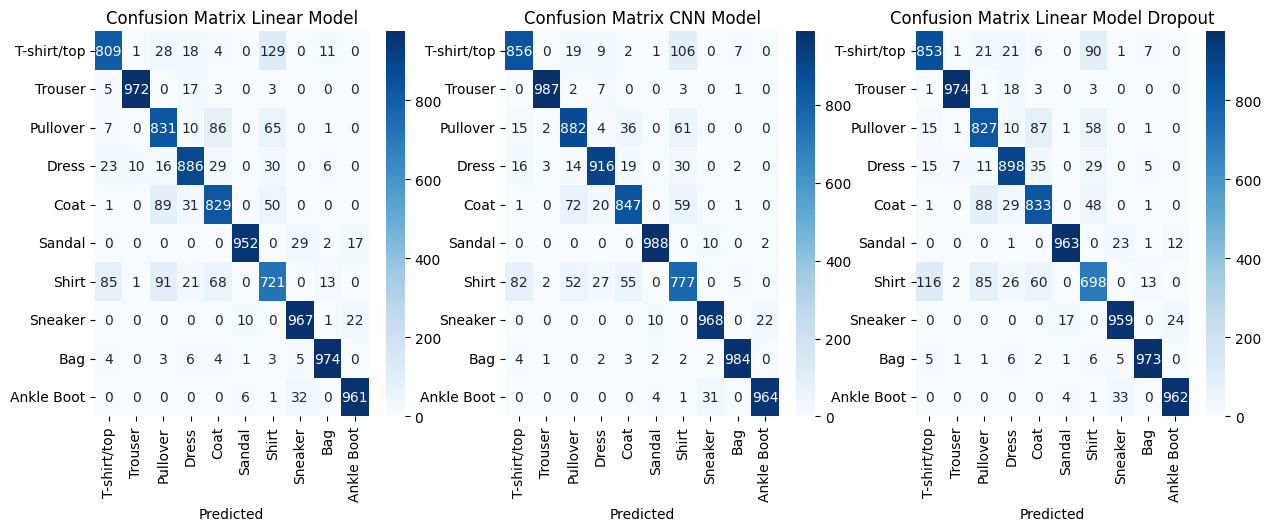

In [15]:
# Plot confusion matrix
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for idx, model in enumerate(models):
    y_pred = model.predict(test_data[idx], verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)
    cm = confusion_matrix(test_labels[idx], y_pred_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, ax=axes[idx])
    axes[idx].set_title(f"Confusion Matrix {model_names[idx]}")
    axes[idx].set_xlabel("Predicted")

plt.show()

In [16]:
for idx, model in enumerate(models):
    loss, accuracy = model.evaluate(
        test_data[idx], test_labels[idx], verbose=0)
    print(f"{model_names[idx]} Accuracy: {accuracy}, Loss: {loss}")

# calculate F1 score, precision, recall for both models
for idx, model in enumerate(models):
    y_pred = model.predict(test_data[idx], verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)
    print(f"{model_names[idx]} F1 Score: {f1_score(test_labels[idx], y_pred_classes, average='macro')}")
    print(f"{model_names[idx]} Precision: {precision_score(test_labels[idx], y_pred_classes, average='macro')}")
    print(f"{model_names[idx]} Recall: {recall_score(test_labels[idx], y_pred_classes, average='macro')}")

Linear Model Accuracy: 0.8902000188827515, Loss: 0.3920334279537201
CNN Model Accuracy: 0.9168999791145325, Loss: 0.2352304458618164
Linear Model Dropout Accuracy: 0.8939999938011169, Loss: 0.37993675470352173
Linear Model F1 Score: 0.8904192842802624
Linear Model Precision: 0.8911027497655416
Linear Model Recall: 0.8902000000000001
CNN Model F1 Score: 0.9171555569665454
CNN Model Precision: 0.9176574157495955
CNN Model Recall: 0.9169
Linear Model Dropout F1 Score: 0.8937271636249383
Linear Model Dropout Precision: 0.8937458449482895
Linear Model Dropout Recall: 0.8939999999999999


In [17]:
m1 = keras.models.load_model("./data/checkpoint-model1.keras")
m1.evaluate(X_test, y_test, verbose=0)


ValueError: File not found: filepath=./data/checkpoint-model1.keras. Please ensure the file is an accessible `.keras` zip file.